# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt 

(1 балл)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

(3 балла)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt

(2 балла)

4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая

(2 балла)

## Import

In [4]:
import os
import hashlib
import collections
import datetime
from base64 import b64encode

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import scipy
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Считаем данные

In [5]:
shop_metrics_new = pd.read_csv('data/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('data/shop_df_users.csv').drop(columns='Unnamed: 0')

shop_metrics_new.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


Создадим функции генерации соли и сплита груп по хешу

In [6]:
def salt_generator(salt=None):
    """ Генератор соли """
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

## 1. T-test и U-test Манна-Уитни на cart_added_cnt

Наша метрика cart_added_cnt - количество товаров, добавленных в корзину

In [7]:
TARGET_METRIC = "cart_added_cnt"

### Взглянем на распределение

Видим, что метрика распределена НЕ нормально, предположительно Манна-Уитни должен пройти лучше

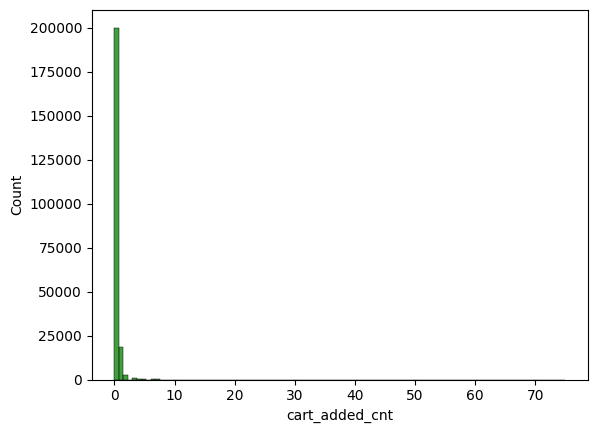

In [15]:
sns.histplot(data=shop_metrics_new, x=TARGET_METRIC, bins=100, color='green')
plt.show()

Глянем на классические стат показатели, видим что как минимум 75% данных нули, но при этом у кого-то количество товаров в корзине достигает 75

In [16]:
shop_metrics_new.groupby('group')[TARGET_METRIC].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


Посмотрим топ 1% перцентиль по количеству товаров, значит больше 6 товаров и ты уже в него попадаешь

In [17]:
np.percentile(shop_metrics_new[TARGET_METRIC], 99.9)

6.0

Посмотрим сколько покупателей в топ 1%, 213 покупателей

In [18]:
shop_metrics_new[shop_metrics_new[TARGET_METRIC] > 6]['user_id'].count()

213

### Мощность и корректность для cart_added_cnt

Дропнем колонку group, чтобы не мешалась

In [8]:
shop = shop_metrics_new.drop(columns=['group'])

Считаем мощность и корректность на t-test

100%|██████████| 1000/1000 [13:20<00:00,  1.25it/s]


0.045735701138158856
 power: 67.10000000000001%, correctness: 95.8%


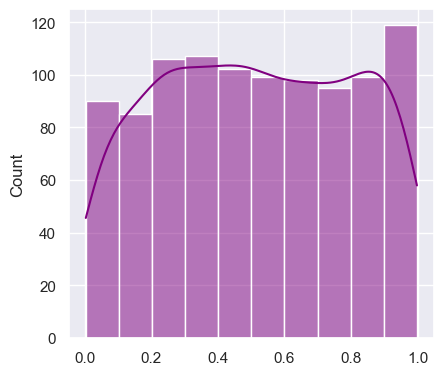

In [22]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')][TARGET_METRIC]
    vec_b = new_df[(new_df['group'] == 'B')][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}%, correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Считаем мощность и корректность на U-test

100%|██████████| 1000/1000 [19:31<00:00,  1.17s/it]


0.05070963940415951
 power: 99.4%, correctness: 95.19999999999999%


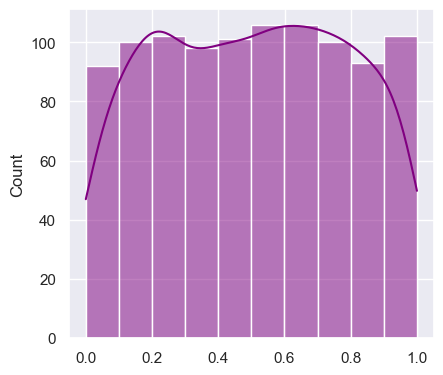

In [23]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')][TARGET_METRIC]
    vec_b = new_df[(new_df['group'] == 'B')][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}%, correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

ВЫВОД: На U-test'e Манна-Уитни мощность значительно выросла и распределение p-value выглядит более равномерно. Данный критерий больше подходит под наши данные

## 2. CUPED

Создадим функцию и сджойним старые и новые данные, чтобы взять старые как covariate

In [6]:
def cuped_transform(df, metrics):
    new_columns = [str(m + '_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m + '_covariate')
        cuped_column = str(m + '_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

### На обычной метрике

Объединим новые и старые данные

In [7]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC])

Сравним средние и дисперсии на группах до и после CUPED

In [9]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC].mean()}')

метрика_cuped A: 0.13638231572657297,         метрика_cuped B: 0.13721028984714181
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [10]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC].var()}')

метрика_cuped A: 0.01823518359964533,         метрика_cuped B: 0.021495363455396536
метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569


Все хорошо: средние сохранились, а дисперсии сократились почти в 20 раз!

Считаем мощность и корректность для CUPED

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


 power: 100.0% , correctness: 95.0%


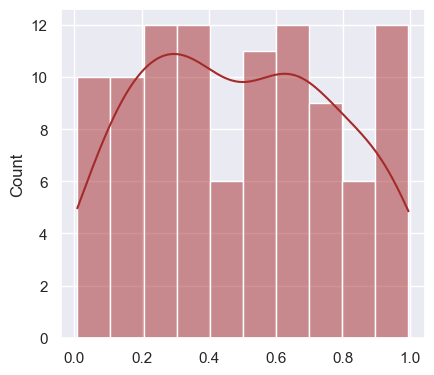

In [27]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
    all_df = all_df.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})

    cuped_df = cuped_transform(all_df, [TARGET_METRIC])

    vec_a = cuped_df[(cuped_df['group'] == 'A')][f'{TARGET_METRIC}_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')][f'{TARGET_METRIC}_cuped']
    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### На прологарифмированной метрике

Создаем логарифмированную метрику

In [13]:
TARGET_METRIC_LN = TARGET_METRIC + "_ln"
shop_metrics_new[TARGET_METRIC_LN] = np.log(shop_metrics_new[TARGET_METRIC] + 1)
shop_metrics_old[TARGET_METRIC_LN] = np.log(shop_metrics_old[TARGET_METRIC] + 1)
shop[TARGET_METRIC_LN] = np.log(shop[TARGET_METRIC] + 1)

Объединим данные

In [14]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', TARGET_METRIC_LN]], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={f'{TARGET_METRIC_LN}_x': TARGET_METRIC_LN, f'{TARGET_METRIC_LN}_y': f'{TARGET_METRIC_LN}_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC_LN])

Сравним средние и дисперсии на группах до и после CUPED для логарифмированной метрики

In [15]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC_LN}_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC_LN}_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC_LN].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC_LN].mean()}')

метрика_cuped A: 0.08034157852348374,         метрика_cuped B: 0.08072086382541542
метрика без cuped A: 0.07974289062640032,         метрика без cuped B: 0.08132020317245879


In [17]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC_LN}_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC_LN}_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC_LN].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC_LN].var()}')

метрика_cuped A: 0.002055014378642917,         метрика_cuped B: 0.0017558187333519078
метрика без cuped A: 0.06466232955752058,         метрика без cuped B: 0.06628259108478471


Средние сохранились, а дисперсии сократились в 30-35 раз!

Считаем мощность и корректность

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


 power: 100.0% , correctness: 98.0%


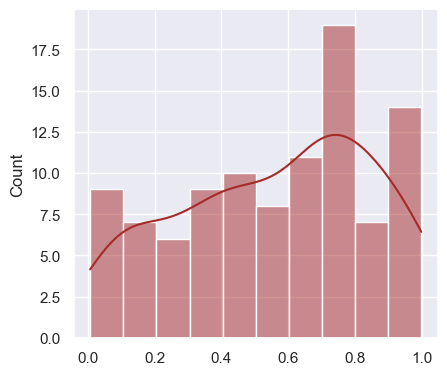

In [31]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', TARGET_METRIC_LN]], on=['user_id'], how='left')
    all_df = all_df.rename(columns={f'{TARGET_METRIC_LN}_x': TARGET_METRIC_LN, f'{TARGET_METRIC_LN}_y': f'{TARGET_METRIC_LN}_covariate'})

    cuped_df = cuped_transform(all_df, [TARGET_METRIC_LN])

    vec_a = cuped_df[(cuped_df['group'] == 'A')][f'{TARGET_METRIC_LN}_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')][f'{TARGET_METRIC_LN}_cuped']
    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### На обычной + ранговое преобразование

Создадим функцию рангового преобразования

In [18]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    
    return df

Объединяем и преобразуем метрику

In [19]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC])

ranked_df = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'], shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], f'{TARGET_METRIC}_cuped')

In [21]:
print(f'метрика_cuped A: {ranked_df[ranked_df.group == "A"][f"rank"].mean()}, \
        метрика_cuped B: {ranked_df[ranked_df.group == "B"][f"rank"].mean()}')
print(f'метрика без cuped A: {ranked_df[ranked_df.group == "A"][TARGET_METRIC].mean()}, \
        метрика без cuped B: {ranked_df[ranked_df.group == "B"][TARGET_METRIC].mean()}')

метрика_cuped A: 111157.3299691882,         метрика_cuped B: 111364.78283723022
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [23]:
print(f'метрика_rank_cuped A: {ranked_df[ranked_df.group == "A"][f"rank"].var()}, \
        метрика_rank_cuped B: {ranked_df[ranked_df.group == "B"][f"rank"].var()}')
print(f'метрика без cuped A: {ranked_df[ranked_df.group == "A"][TARGET_METRIC].var()}, \
        метрика без cuped B: {ranked_df[ranked_df.group == "B"][TARGET_METRIC].var()}')

метрика_rank_cuped A: 1138307738.193268,         метрика_rank_cuped B: 1151768826.5589178
метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569


У нас изменились средние, дисперсии при этом выросли

Но главный плюс ранговой трансформации в преобразовании разности средних, она стала ниже => t-test увереннее в том что различий нет => мощность повышается

Разность средних до преобразования

In [26]:
print((ranked_df[ranked_df.group == 'B'][TARGET_METRIC].mean() - ranked_df[ranked_df.group == 'A'][TARGET_METRIC].mean()) / ranked_df[ranked_df.group == 'A'][TARGET_METRIC].mean()*100)

2.5993801047766807


После преобразования:

In [25]:
print((ranked_df[ranked_df.group == 'B']['rank'].mean() - ranked_df[ranked_df.group == 'A']['rank'].mean()) / ranked_df[ranked_df.group == 'A']['rank'].mean()*100)

0.186629948829756


Мощность и корректность для ранговой трансформации

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


 power: 100.0% , correctness: 96.0%


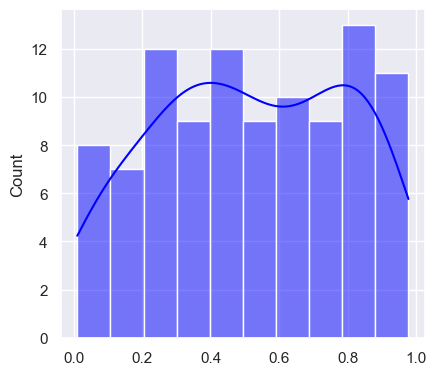

In [34]:
correctness = []
power = []

for i in tqdm(range(100)):
    # сначала cuped
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
    all_df = all_df.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})

    cuped_df = cuped_transform(all_df, [TARGET_METRIC])

    # потом ранговое преобразование по cuped'у
    ranked_df = rank_transformation(cuped_df[cuped_df.group == 'A'], cuped_df[cuped_df.group == 'B'], f'{TARGET_METRIC}_cuped')
    
    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']
    
    vec_b_effect = cuped_df[cuped_df['group'] == 'B'][f'{TARGET_METRIC}_cuped'] * 1.05
    new_df_b = cuped_df[cuped_df.group == 'B'].drop(columns=[f'{TARGET_METRIC}_cuped'])
    new_df_b[f'{TARGET_METRIC}_cuped'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(cuped_df[cuped_df.group == 'A'], new_df_b, f'{TARGET_METRIC}_cuped')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

ВЫВОД: CUPED на исходной метрике уже показал максимальную мощность, можно было бы не идти дальше.

Но при этом видим что все преобразования также дали максимальную мощность, а значит имеют право на существование

## 3. Разбивка на бакеты

Главная идея - изначально у нас каждое наблюдение независимо, сгруппируем наблюдения по бакетам (в моем примере 100 бакетов)

Тогда даже несмотря на случайное разбиение, средние будут поглаже чем независимые наблюжиения => дисперсия уменьшится

### Логнормальное распределение

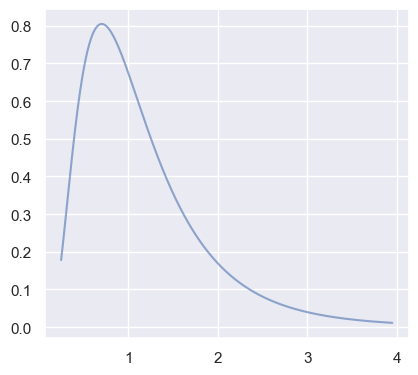

In [46]:
s = 0.59
x = np.linspace(scipy.stats.lognorm.ppf(0.01, s),
                scipy.stats.lognorm.ppf(0.99, s), 40000)

data = stats.lognorm.pdf(x, s)
plt.plot(x, data, lw=1.5, alpha=0.6)
plt.show()

Бьем на бакеты (но сначала перемешаем, так будет интереснее)

In [51]:
np.random.seed(59)

data = np.random.permutation(data)

df_lognormal = pd.DataFrame({"target": data})
df_lognormal['user_id'] = df_lognormal.index
df_lognormal['bucket_num'] = df_lognormal["user_id"] % 1000
df_lognormal.head()

,target,user_id,bucket_num
0,0.070398,0,0
1,0.187166,1,1
2,0.103162,2,2
3,0.718505,3,3
4,0.015390,4,4


Мощность и корректность исходная

100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]


0.03719679261982034
 power: 95.0% , correctness: 94.6%


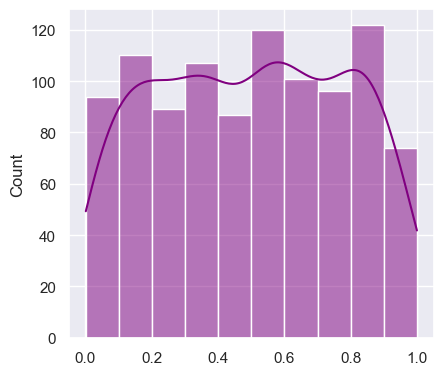

In [33]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(df_lognormal.copy(), user_salt=salt_generator())
    new_df = pd.merge(df_lognormal, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')]['target']
    vec_b = new_df[(new_df['group'] == 'B')]['target']
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Саггрегируем

In [52]:
df_ln_bucket = df_lognormal.groupby("bucket_num")["target"].mean().to_frame().reset_index(drop=False)
df_ln_bucket['user_id'] = df_ln_bucket['bucket_num']
df_ln_bucket.head()

,bucket_num,target,user_id
0,0,0.212965,0
1,1,0.288619,1
2,2,0.275995,2
3,3,0.349667,3
4,4,0.257294,4


In [53]:
len(df_ln_bucket)

1000

Мощность и корректность t-test для бакетов

100%|██████████| 1000/1000 [00:09<00:00, 105.41it/s]


0.07131455702488802
 power: 12.7% , correctness: 95.8%


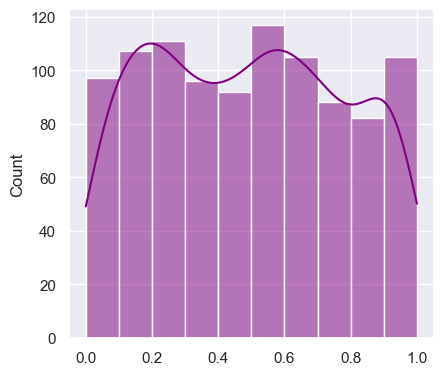

In [54]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(df_ln_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(df_ln_bucket, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')]['target']
    vec_b = new_df[(new_df['group'] == 'B')]['target']
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Кажется т-тест не может отловить неконстантное изменение в 5% у бакетов, мощность категорически упала, попробуем константный эффект для каждого бакета

100%|██████████| 1000/1000 [00:09<00:00, 107.83it/s]


0.046772010439241576
 power: 99.7% , correctness: 95.39999999999999%


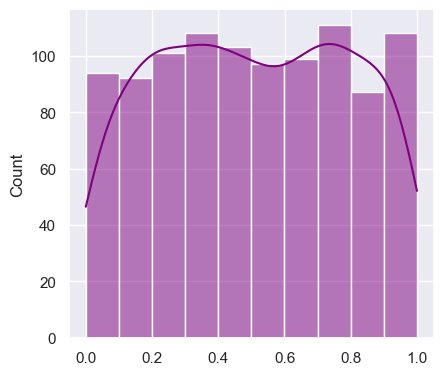

In [55]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(df_ln_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(df_ln_bucket, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')]['target']
    vec_b = new_df[(new_df['group'] == 'B')]['target']
    vec_b_effect = vec_b + vec_b.mean() * 0.05
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

При константом увеличении эффекта на каждом бакете мощность близка к максимальной

### Бакетирование на наших данных

In [56]:
shop_bucket = shop.copy()
shop_bucket['bucket_num'] = shop_bucket.index % 1000
shop_bucket.head()

,user_id,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,bucket_num
0,1515915625353230683,1,1,339.79,0.0,0.0,0,0,0
1,1515915625353234047,1,9,861.86,0.0,0.0,0,0,1
2,1515915625353236157,1,4,179.60,0.0,0.0,0,0,2
3,1515915625353294441,1,28,4283.04,0.0,0.0,0,0,3
4,1515915625353386199,1,1,20.98,0.0,0.0,0,0,4


In [58]:
shop_bucket = shop_bucket.groupby("bucket_num")[TARGET_METRIC].mean().to_frame().reset_index(drop=False)
shop_bucket['user_id'] = shop_bucket['bucket_num']
shop_bucket.head()

,bucket_num,cart_added_cnt,user_id
0,0,0.076233,0
1,1,0.143498,1
2,2,0.134529,2
3,3,0.062780,3
4,4,0.094170,4


Мощность и корректность на бакетах

100%|██████████| 1000/1000 [00:09<00:00, 102.89it/s]


0.10099987073152218
 power: 6.7% , correctness: 95.39999999999999%


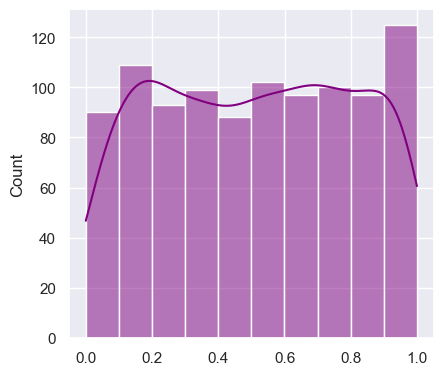

In [60]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(shop_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop_bucket, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')][TARGET_METRIC]
    vec_b = new_df[(new_df['group'] == 'B')][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Как и прежде, из-за бакетов наша мощность, проверенная на случайном добавлении эффекта упала

Оно может иметь хорошую эвристическую подоплеку, как пример бакетов у нас 1000, а данных 222к

=> каждый бакет примерно по 222 наблюдения, вероятность отсутствия эффекта среди всех 222 случайно перемешанных наблюдений мала

=> случайное добавление эффекта справляется не очень и необходимо константное

100%|██████████| 1000/1000 [00:09<00:00, 106.42it/s]


0.04874259929492869
 power: 71.7% , correctness: 95.0%


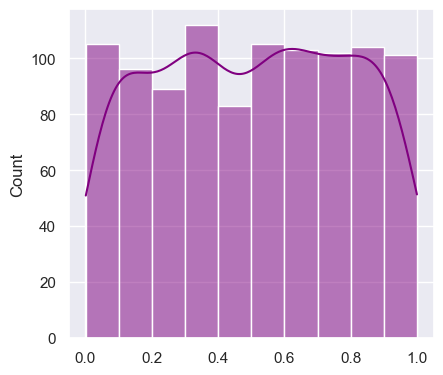

In [63]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(shop_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop_bucket, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')][TARGET_METRIC]
    vec_b = new_df[(new_df['group'] == 'B')][TARGET_METRIC]
    vec_b_effect = vec_b + vec_b.mean() * 0.05
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

При константном добавлении эффекта получаем мощность выше чем на исходной метрике (71.7% vs 67.1%)

ВЫВОД: Бакеты дают прирост мощности, но только если оценивать мощность по константному добавлению эффекта, потому что иначе мощность категорически падает

## 4. Постстратификация

In [77]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')
shop_w_features.drop(["is_viewed", "is_viewed", "products_viewed_cnt", "price_sum", "is_cart_added", "is_purchased", "purchased_cnt"], axis=1, inplace=True)
shop_w_features.head()

,user_id,group,cart_added_cnt,user_age,user_sex
0,1515915625353226922,B,0,55,f
1,1515915625353230067,A,0,58,m
2,1515915625353230683,A,0,23,f
3,1515915625353230922,A,0,33,m
4,1515915625353234047,A,0,26,f


In [79]:
def map_age(age: int):
    if age in range(18, 25):
        return "18-24"
    elif age in range(25, 46):
        return "25-45"
    elif age in range(46, 61):
        return "45-60"
    elif age in range(61, 76):
        return "61-75"
    else:
        return "76+"


shop_w_features['age_group'] = shop_w_features['user_age'].apply(map_age)
shop_w_features['sex_age_group'] = shop_w_features['user_sex'] + "_" + shop_w_features['age_group']
shop_w_features.head()

,user_id,group,cart_added_cnt,user_age,user_sex,age_group,sex_age_group
0,1515915625353226922,B,0,55,f,45-60,f_45-60
1,1515915625353230067,A,0,58,m,45-60,m_45-60
2,1515915625353230683,A,0,23,f,18-24,f_18-24
3,1515915625353230922,A,0,33,m,25-45,m_25-45
4,1515915625353234047,A,0,26,f,25-45,f_25-45


Слишком мало молодых девчонок, в остальном более менее равномерно

In [80]:
shop_w_features.groupby(['group'])['sex_age_group'].value_counts()

group  sex_age_group
A      m_25-45          38432
       m_45-60          27321
       m_61-75          27001
       f_25-45          25540
       f_45-60          18336
       f_61-75          17939
       m_76+            16249
       m_18-24          12890
       f_76+            11125
       f_18-24           8503
B      m_25-45          38490
       m_45-60          27283
       m_61-75          27249
       f_25-45          25439
       f_61-75          18246
       f_45-60          18111
       m_76+            16362
       m_18-24          12816
       f_76+            11082
       f_18-24           8449
Name: count, dtype: int64

### Сравним средние и дисперсии до постстратификации и после

На исходной выборке, t-test

In [81]:
stats.ttest_ind(shop_w_features[shop_w_features.group == 'A'][TARGET_METRIC], 
                shop_w_features[shop_w_features.group == 'B'][TARGET_METRIC])

TtestResult(statistic=-0.7331870372707812, pvalue=0.4634447828246868, df=406861.0)

Разность средних

In [82]:
(shop_w_features[shop_w_features.group == 'B'][TARGET_METRIC].mean() - shop_w_features[shop_w_features.group == 'A'][TARGET_METRIC].mean()) / shop_w_features[shop_w_features.group == 'A'][TARGET_METRIC].mean() * 100

1.1242734540045785

Дисперсии

In [83]:
print(shop_w_features[shop_w_features.group == 'A'][TARGET_METRIC].std(), 
      shop_w_features[shop_w_features.group == 'B'][TARGET_METRIC].std())

0.576689119780438 0.5987645651973791


На постстратификации по полу и возрастной группе

In [90]:
N = shop_w_features['user_id'].nunique()

strats_weights = {}
for i in range(shop_w_features['sex_age_group'].nunique()):
    key = shop_w_features['sex_age_group'].value_counts().index[i]
    strats_weights[key] = shop_w_features['sex_age_group'].value_counts().iloc[i] / N

strats_weights

{'m_25-45': 0.18906118275684936,
 'm_45-60': 0.1342073376050415,
 'm_61-75': 0.13333726586099007,
 'f_25-45': 0.12529770463276335,
 'f_45-60': 0.08958052219051622,
 'f_61-75': 0.08893657078672673,
 'm_76+': 0.08015228713350686,
 'm_18-24': 0.06318097246493291,
 'f_76+': 0.05458102604562224,
 'f_18-24': 0.04166513052305076}

Логика такая, что выборки у нас становятся независимы, а потому общая дисперсия - средняя усредненная дисперсия выборок (как и среднее)

In [91]:
mean_a = 0
mean_b = 0

std_a = 0
std_b = 0

for sex_age in strats_weights:
    mean_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].mean() * strats_weights[sex_age]
    mean_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].mean() * strats_weights[sex_age]

    std_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].std()**2 * strats_weights[sex_age]
    std_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].std()**2 * strats_weights[sex_age]

std_a, std_b = std_a / N, std_b / N

n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

print(f'effect: {(mean_b - mean_a) / mean_a * 100}, std_a: {std_a}, std_b: {std_b}')

stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

effect: 1.1238909894351434, std_a: 8.179175411681481e-07, std_b: 8.814427810322829e-07


Ttest_indResult(statistic=-506738.4365829322, pvalue=0.0)

Видим что разность средних не изменилась, но дисперсия уменьшилась многократно.

T-test также показывает что различия между группами найти практически невозможно, значит мы также уменьшили ошибку первого рода

### Мощность и корректность

Считаем мощность корректность на каждой группе, и находим общие мощность и корректность как взвешенные средние

In [94]:
shop_new = shop_w_features.drop("group", axis=1)

In [109]:
corr_group = 0
power_group = 0

for sex_age in tqdm(strats_weights):
    correctness = []
    power = []
    for _ in range(5):
        new_group = groups_splitter(shop_new.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop_new, new_group, how="left", on=['user_id']).drop_duplicates()

        vec_a = new_df[(new_df.group == 'A') & (new_df['sex_age_group'] == sex_age)][TARGET_METRIC]
        vec_b = new_df[(new_df.group == 'B') & (new_df['sex_age_group'] == sex_age)][TARGET_METRIC]
        vec_b_effect = vec_b + vec_b.mean() * 0.05

        p_cor_group, p_power_group = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]

        correctness.append(p_cor_group)
        power.append(p_power_group)

    correctness = np.array(correctness)
    power = np.array(power)

    power_group += (power[power < 0.05].shape[0] / power.shape[0]) * strats_weights[sex_age]
    corr_group += (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * strats_weights[sex_age]

# sns.set(rc={'figure.figsize':(4.7,4.27)})
# sns.histplot(data=correctness, bins=10, color='purple', kde=True)
# print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
# print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')
print(f' power: {power_group * 100}% , correctness: {corr_group * 100}%')

100%|██████████| 10/10 [01:17<00:00,  7.78s/it]

 power: 24.583754236684097% , correctness: 95.54164423896987%


ВЫВОД: не совсем понял как считать мощность и корректность на постстратификации, по разному пробовал усреднять по группам, все время мощность близится к нулю (критически меньше чем у исходной выборки)